# **Podemos prever quem teria sobrevivido ao Titanic?**

Este notebook passa por uma análise exploratória básica de dados utilizando um conjunto de dados que pode ser encontrado no [Kaggle](https://www.kaggle.com/c/titanic). 

Os dados utilizados fazem parte de uma das mais famosas competições do site, o Titanic dataset. 

Além da análise, foi construído um modelo de classificação, onde desafiamos a máquina a prever sobreviventes do titanic com base em dados de outros passageiros.

In [ ]:
# importando as bibliotecas que serão utilizadas
%matplotlib inline
import pandas as pd
import numpy as np
import re

import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# leitura dos dados
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submisson = pd.read_csv('test.csv')

# criando uma lista e incluindo os datasets
full_data = [train, test]

## Dicionário das colunas

**Survival**: Sobrevivente (0 = Não, 1 = Sim)

**Pclass (Ticket class)**: Classe do ingresso (1 = 1ª classe, 2 = 2ª classe, 3 = 3ª classe)

**Sex**: Sexo (female = Feminino, male = Masculino)

**Age**: Idade do passageiro

**Sibsp**: Número de irmãos/cônjuges a bordo do Titanic

**Parch**: Número de pais / filhos a bordo do Titanic

**Ticket**: Número do bilhete

**Fare**: Tarifa de passageiro

**Cabin**: Número da cabine

**Embarked**: Porto de embarcação (C = Cherbourg, Q = Queenstown, S = Southampton)

In [ ]:
# 5 primeiras entradas do nosso DataFrame de treino
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# 5 primeiras entradas do nosso DataFrame de teste
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# dimensão do DataFrame de treino
train.shape 
print(f'Linhas: {train.shape[0]}')
print(f'Colunas: {train.shape[1]}')

Linhas: 891
Colunas: 12


Através da função *info()* obtemos informações como: 
quais são as variáveis do DataFrame, quais variáveis apresentam valores faltantes, o tipo de dado de cada variável (dtypes), a quantidade de entradas e etc.

In [ ]:
# informações sobre o DataFrame de treino
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Esse dataset apresenta algumas variáveis com valores faltantes, agora vamos ver mais detalhes sobre essas variáveis.





In [ ]:
# quantidade de valores nulos 
train.isna().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

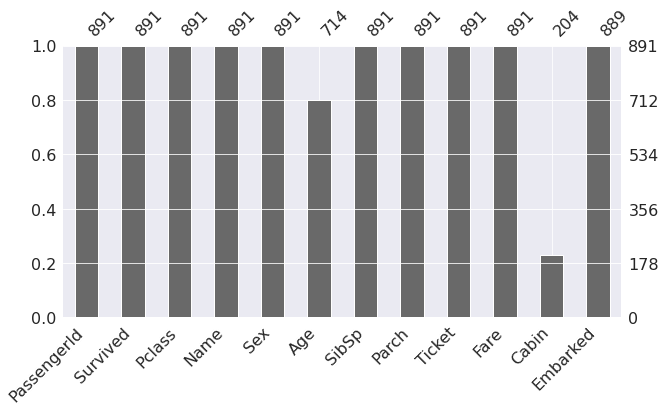

In [ ]:
msno.bar (train, figsize = (10,5))

Concluimos que as colunas com valores ausente são as colunas 'Cabin', 'Age' e 'Embarked'

In [ ]:
# porcentagem de valores nulos (%)
(((train.isna().sum() / len(train)) * 100)).sort_values(ascending=False)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
Fare            0.000000
Ticket          0.000000
Parch           0.000000
SibSp           0.000000
Sex             0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
PassengerId     0.000000
dtype: float64

In [ ]:
# resumo estatístico
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Analisando as variáveis do DataFrame

Para facilitar a análise irei criar dois DataFrames do Pandas separando variáveis numéricas das variáveis categóricas.

In [ ]:
# tipos de dados do dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
df1 = pd.DataFrame() # para variáveis numericas discretas
df2 = pd.DataFrame() # para variáveis numericas continuas

## **1. Explorando e analisando as features do nosso dataset**

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### **1.01 - Target Feature: Survived**

Target Feature é exatamente a variável que queremos que o nosso modelo preveja.

Essa feature nos diz se o passageiro sobreviveu ou não.

0 = Não, 1 = Sim

0    549
1    342
Name: Survived, dtype: int64


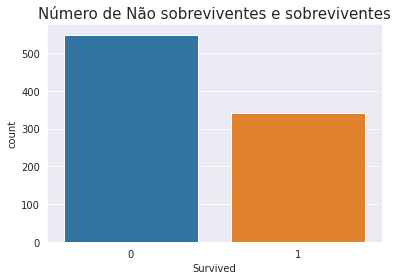

In [ ]:
print(train['Survived'].value_counts())
ax = sns.countplot(x='Survived', data=train)
ax.set_title('Número de Não sobreviventes e Sobreviventes', fontsize=15);

In [ ]:
df1['Survived'] = train['Survived']
df2['Survived'] = train['Survived']

In [ ]:
df1.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [ ]:
df2.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### **1.02 - Feature: Pclass**

Classe de ingresso do passageiro.

1 = 1ª classe, 2 = 2ª classe, 3 = 3ª classe

Podemos ver que os valores dessa variável é numérica mas que em sua essencial se apresenta de forma categórica.

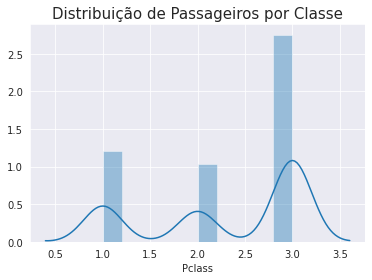

In [ ]:
ax = sns.distplot(train['Pclass'])
ax.set_title('Distribuição de Passageiros por Classe', fontsize=15);

Survived
Pclass Survived          
1      0               80
       1              136
2      0               97
       1               87
3      0              372
       1              119

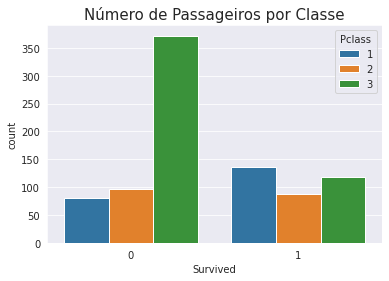

In [ ]:
display(train.groupby(['Pclass', 'Survived']).agg({'Survived' : 'count'}))

ax = sns.countplot(x='Survived', data=train, hue='Pclass')
ax.set_title('Número de Passageiros por Classe', fontsize= 15);

Claramente podemos notar que as maiores vítimas do naufragio foram passageiros da 3ª Classe

In [ ]:
df1['Pclass'] = train['Pclass'] 
df2['Pclass'] = train['Pclass'] 

### **1.02 - Feature: Name**

Nome dos passageiros



In [ ]:
train.Name.value_counts()

Morrow, Mr. Thomas Rowan                        1
Leader, Dr. Alice (Farnham)                     1
Turkula, Mrs. (Hedwig)                          1
Sivola, Mr. Antti Wilhelm                       1
White, Mr. Richard Frasar                       1
                                               ..
Taussig, Mrs. Emil (Tillie Mandelbaum)          1
Harris, Mrs. Henry Birkhardt (Irene Wallach)    1
Foo, Mr. Choong                                 1
Holm, Mr. John Fredrik Alexander                1
Hansen, Mr. Claus Peter                         1
Name: Name, Length: 891, dtype: int64

### **1.03 - Feature: Sex**

Sexo dos passageiros

female = Feminino, male = Masculino

Survived
Sex    Survived          
female 0               81
       1              233
male   0              468
       1              109

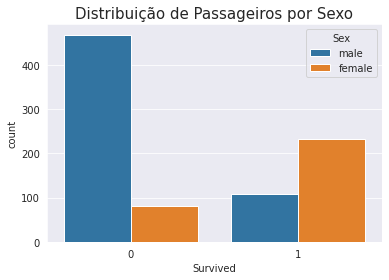

In [ ]:
display(train.groupby(['Sex', 'Survived']).agg({'Survived' : 'count'}))

ax = sns.countplot(x='Survived', data=train, hue='Sex')
ax.set_title('Distribuição de Passageiros por Sexo', fontsize= 15);

Aqui podemos notar que houve um número maior de sobreviventes do sexo feminino. 

Isso nos remete a uma das cenas famosas do filme Titanic, onde as mulheres e crianças tinham prioridade para entrar nos botes salva vidas.

In [ ]:
df1['Sex'] = train['Sex']
df2['Sex'] = train['Sex']

In [ ]:
# mudando o sexo para 0 para masculino e 1 para feminino
df1['Sex'] = np.where(df1['Sex'] == 'male', 0, 1)

In [ ]:
df1['Sex'].head()

0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64

### **1.04 - Feature: Age**

Idade dos passageiros.

In [ ]:
# essa é uma das variáveis que possuem missing values (valores faltantes)
# quantos valores faltantes 'Age' possui?
train['Age'].isna().sum()

177

In [ ]:
# como vimos no início deste notebook, a variável 'Age' possui quase 20% dos seus valores como NaN
# como podemos tratar esse dados?

# calculando a média e o desvio padrão
media = train['Age'].mean()
desvio = train['Age'].std()

print(f'Média Idade: {media}')
print(f'Desvio Padrão: {desvio}')

Média Idade: 29.69911764705882
Desvio Padrão: 14.526497332334044


In [ ]:
# podemos substituir os valores nulos de forma aleatória com valores que estejam dentro do intervalo [média - desvio, média + desvio]
age_avg = train['Age'].mean() #retorna a média da idade
age_std = train['Age'].std()  #retorna o desvio padrão
age_null_count = train['Age'].isnull().sum() #conta a quantidade de campos nulos
    
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
train['Age'][np.isnan(train['Age'])] = age_null_random_list
train['Age'] = train['Age'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# agrupando em categorias     
df1['Age'] = pd.cut(train['Age'], 10)
df2['Age'] = train['Age'] 

In [ ]:
df1['Age'].value_counts()

(16.0, 24.0]    228
(24.0, 32.0]    216
(32.0, 40.0]    169
(40.0, 48.0]     87
(8.0, 16.0]      57
(-0.08, 8.0]     54
(48.0, 56.0]     45
(56.0, 64.0]     24
(64.0, 72.0]      9
(72.0, 80.0]      2
Name: Age, dtype: int64

### **1.05 - Feature: SibSp**

Número de irmãos/cônjuges a bordo.

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


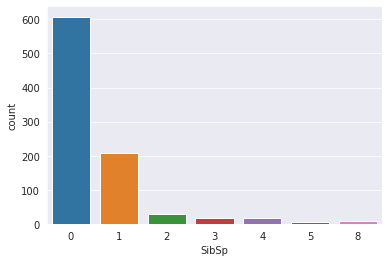

In [ ]:
print(train['SibSp'].value_counts())

sns.countplot(x='SibSp', data=train);

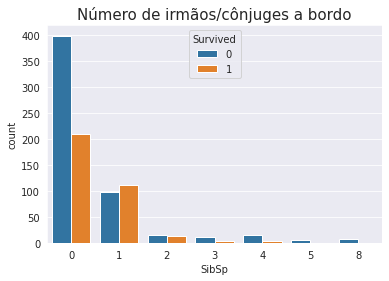

In [ ]:
ax = sns.countplot(x='SibSp', data=train, hue='Survived')
ax.set_title('Número de irmãos/cônjuges a bordo', fontsize=15);

Notamos que passageiros que não possuiam nenhum irmão ou cônjugue a bordo fazem parte da maior parte dos não sobreviventes.

In [ ]:
df1['SibSp'] = train['SibSp']
df2['SibSp'] = train['SibSp']

### **1.06 - Feature: Parch**

Número de pais/filhos a bordo.

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


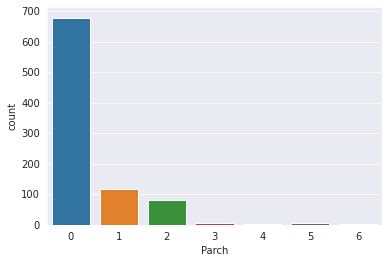

In [ ]:
print(train['Parch'].value_counts())

sns.countplot(x='Parch', data=train);

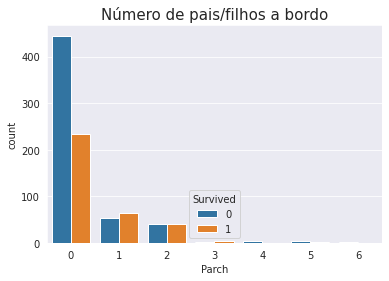

In [ ]:
ax = sns.countplot(x='Parch', data=train, hue='Survived')
ax.set_title('Número de pais/filhos a bordo', fontsize=15);

Podemos fazer uma ligação com a análise anterior, onde obersamos o comportamento da feature 'SbiSp'. 

Aqui também vemos um comportamento parecido, onde o número maior de não sobreviventes está relacionado ao fato do passageiro não possuir acompanhantes a bordo.

In [ ]:
df1['Parch'] = train['Parch']
df2['Parch'] = train['Parch']

### **1.07 - Feature: Ticket**

O número do ticket do passageiro.

In [ ]:
train['Ticket'].value_counts()

CA. 2343     7
347082       7
1601         7
CA 2144      6
3101295      6
            ..
345763       1
349249       1
3101267      1
S.P. 3464    1
4135         1
Name: Ticket, Length: 681, dtype: int64

In [ ]:
# quantos tipos únicos de ticket existem?
len(train['Ticket'].unique())

681

### **1.08 - Feature: Fare**

Valor da tarifa paga pelo passageiro

In [ ]:
train['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

In [ ]:
# quantos tipos únicos de tarifa existem?
len(train['Fare'].unique())

248

In [ ]:
# agrupando em categorias  
df2['Fare'] = pd.cut(train['Fare'], bins=4)
df1['Fare'] = train['Fare'] 

In [ ]:
df2['Fare'].value_counts()

(-0.512, 128.082]     853
(128.082, 256.165]     29
(256.165, 384.247]      6
(384.247, 512.329]      3
Name: Fare, dtype: int64

### **1.09 - Feature: Cabin**

Número da cabine do passageiro.



In [ ]:
train['Cabin'].value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
D              3
F2             3
              ..
E10            1
A31            1
C104           1
C49            1
A5             1
Name: Cabin, Length: 147, dtype: int64

In [ ]:
# essa é uma variável que possui valores NaN, como vimos anteriormente
# como existem muito valores NaN não irei considerar essa variável para ser implementada no modelo
train['Cabin'].isna().sum()

687

### **1.09 - Feature: Embarked**

Porto de embarcação que o passageiro embarcou

C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

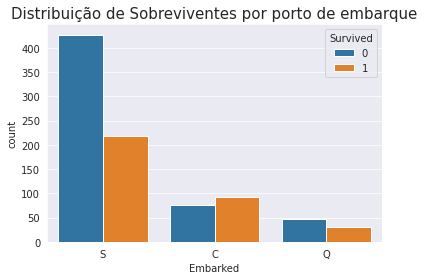

In [ ]:
ax = sns.countplot(data=train, x='Embarked', hue='Survived')
ax.set_title('Distribuição de Passageiros por porto de embarque', fontsize= 15);

In [ ]:
# essa variável possui poucos valores NaN
print('Valores NaN: {}'.format(train['Embarked'].isna().sum()))

# irei excluir esses valores
train['Embarked'].dropna(inplace=True)

Valores NaN: 2


In [ ]:
df1['Embarked'] = train['Embarked']
df2['Embarked'] = train['Embarked']

## Feature Enconding